<a href="https://colab.research.google.com/github/OluwatobaAdeoye/EARLY-STAGE-PREDICTION-OF-ALZHEMIER-S-DISEASE-USING-DEEP-LEARNING-ON-STRUCTURAL-MRI-DATA/blob/main/Alzheimer_Project_(code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TITLE: EARLY-STAGE PREDICTION OF ALZHEIMER'S DISEASE USING DEEP LEARNING ON STRUCTURAL MRI DATA**

## Import the necessary libraries

In [26]:
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/train'
test_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/test'

## Data pre-processing

In [4]:
# combine both classes
all_folders =[train_dataset,test_dataset]

## initialize counters
total_images = 0
classes=set()

## count images and get class names
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path): ## it must be a folder
            classes.add(class_name)
            total_images += len(os.listdir(class_path))
## print the elements
print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')


total images:6401
classes:4
classes:{'MildDemented', 'NonDemented', 'VeryMildDemented', 'ModerateDemented'}


In [5]:
total_dir='/content/drive/MyDrive/Alzheimer_dataset/dir'

## ensure the directory exist
os.makedirs(total_dir,exist_ok=True)

## combine dataset
all_folders=[train_dataset,test_dataset]

##  initialize both dataset
total_images=0
classes =set()

##  copy imges new directory
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path=os.path.join(folder,class_name)
        if os.path.isdir(class_path):
            classes.add(class_name)
            ## create class folder in the new directory
            new_class=os.path.join(total_dir,class_name)
            os.makedirs(new_class,exist_ok=True)
            ## copy images to the new directory
            for image_name in os.listdir(class_path):
                image_path=os.path.join(class_path,image_name)
                new_image_path=os.path.join(new_class,image_name)
                shutil.copy(image_path,new_image_path)
                total_images+=1

print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')

total images:6401
classes:4
classes:{'MildDemented', 'NonDemented', 'VeryMildDemented', 'ModerateDemented'}


In [6]:
split_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split'
## define the diir
train_dir = os.path.join(split_data, 'train')
test_dir = os.path.join(split_data, 'test')
val_dir = os.path.join(split_data, 'valid')
## checking if the directoey exist
for  folder in[train_dir,test_dir,val_dir]:
    os.makedirs(folder,exist_ok=True)
## initialise counters
total_images=0
classes = set()


In [7]:


# Define dataset paths
original_dataset = "/content/drive/MyDrive/Alzheimer_dataset/dir"
output_dir = "/content/drive/MyDrive/Alzheimer_dataset/dir_split"
##
# Define split directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
valid_dir = os.path.join(output_dir, "valid")

# Ensure output directories exist##
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(folder, exist_ok=True)

# Initialize counters
total_images = 0
classes = set()

# Split dataset
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if os.path.isdir(class_path):  # Ensure it's a folder
        classes.add(class_name)

        # Create class subfolders in train, test, and valid directories
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)
        valid_class_path = os.path.join(valid_dir, class_name)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)

        # Get all images and shuffle
        images = os.listdir(class_path)
        random.shuffle(images)

        # Split into 80-10-10
        train_split = int(0.8 * len(images))
        test_split = int(0.9 * len(images))  # 90% point (test + valid)

        train_images = images[:train_split]
        test_images = images[train_split:test_split]
        valid_images = images[test_split:]

        # Copy images to respective folders
        for image in train_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(train_class_path, image))

        for image in test_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(test_class_path, image))

        for image in valid_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(valid_class_path, image))

        total_images += len(images)

# Print results
print(f"Total Images: {total_images}")
print(f"Total Classes: {len(classes)}")
print(f"Class Names: {classes}")
print("Dataset successfully split into Train (80%), Test (10%), and Validation (10%)")


Total Images: 6401
Total Classes: 4
Class Names: {'MildDemented', 'NonDemented', 'VeryMildDemented', 'ModerateDemented'}
Dataset successfully split into Train (80%), Test (10%), and Validation (10%)


In [8]:
def count_images(split_data):
    split_count = {}  # Initialize split_count as an empty dictionary
    for class_name in os.listdir(split_data):
        class_path = os.path.join(split_data, class_name)
        if os.path.isdir(class_path):
            split_count[class_name] = len(os.listdir(class_path))
    return split_count
# counting total element in split data
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
valid_counts = count_images(valid_dir)

## print result
print ('\nTrain Dataset:')
for class_name, count in train_counts.items():
    print(f'{class_name}:{count} images')
print ('\nTest Dataset:')
for class_name, count in test_counts.items():
    print(f'{class_name}:{count} images')
print ('\nValid Dataset:')
for class_name, count in valid_counts.items():
    print(f'{class_name}:{count} images')


Train Dataset:
VeryMildDemented:1792 images
MildDemented:716 images
ModerateDemented:51 images
NonDemented:2560 images

Test Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:6 images
NonDemented:320 images

Valid Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:7 images
NonDemented:321 images


In [3]:
train_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/train'
test_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/test'
valid_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/valid'

In [4]:
def get_info_on_the_dataset (dataset_path):
  classes =os.listdir(dataset_path)
  total_images= sum([len(os.listdir(os.path.join(dataset_path,class_name))) for class_name in classes])
  return classes,total_images


total_train, total_class_train=get_info_on_the_dataset(train_data)
total_test,total_class_test=get_info_on_the_dataset(test_data)
total_valid,total_class_valid=get_info_on_the_dataset(valid_data)
## print each element
print(f'classes:{total_class_train},total train images:{total_train}')
print(f'classes:{total_class_test},total test images:{total_test}')
print(f'classes:{total_class_valid},total test images:{total_valid}')

classes:5119,total train images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
classes:640,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
classes:642,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


## loading the train dataset

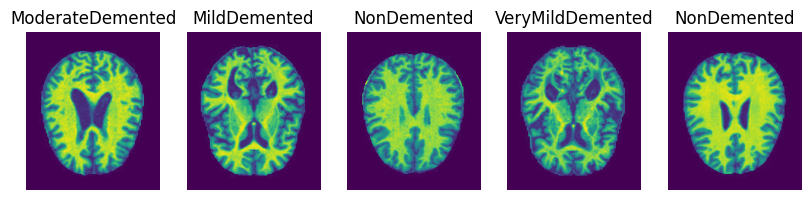

In [5]:
## get classes
classes = [d for d in os.listdir(train_data) if os.path.isdir(os.path.join(train_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(train_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## test dataset

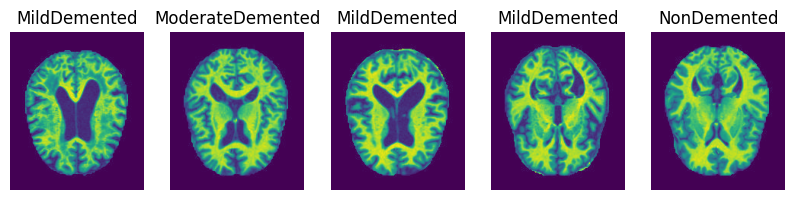

In [6]:
## get classes
classes = [d for d in os.listdir(test_data) if os.path.isdir(os.path.join(test_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(test_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## valid dataset

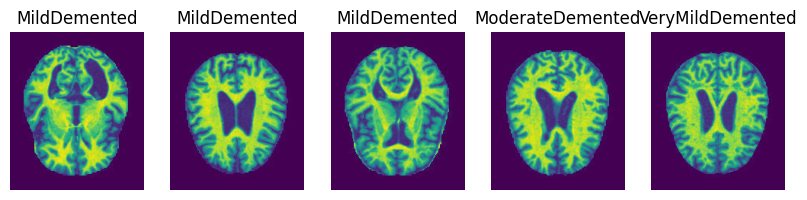

In [7]:
## get classes
classes = [d for d in os.listdir(valid_data) if os.path.isdir(os.path.join(valid_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(valid_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1) # Creating 5 subplots in a 1x5 grid
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## Exploratory dataset analysis (EDA)

graphs for the train dataset

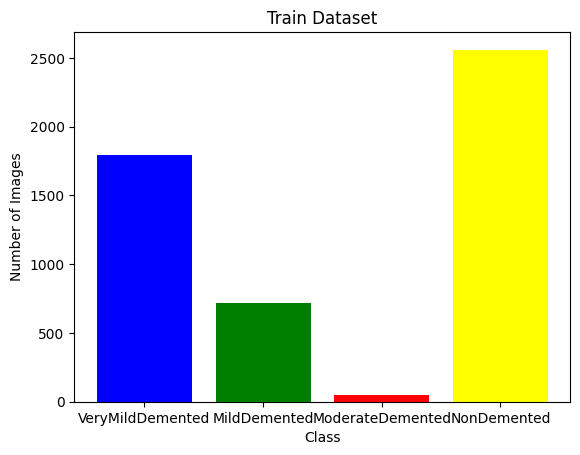

In [8]:
##  count image per class
train_counts= {class_name:len(os.listdir(os.path.join(train_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(train_counts.keys(), train_counts.values(), color=['blue','green','red','yellow'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Train Dataset')
plt.show()

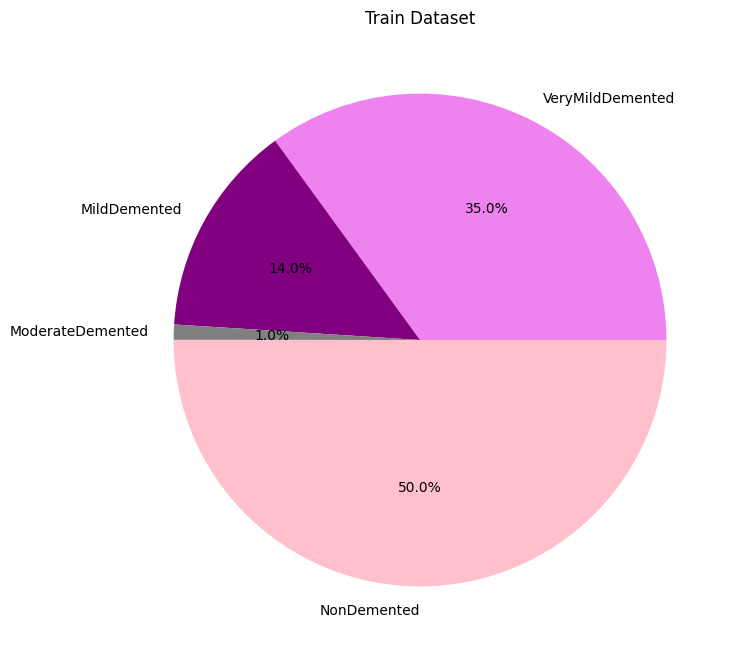

In [9]:
colors=['violet','purple','grey','pink']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(train_counts.values(),labels=train_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('Train Dataset')
plt.show()

test dataset

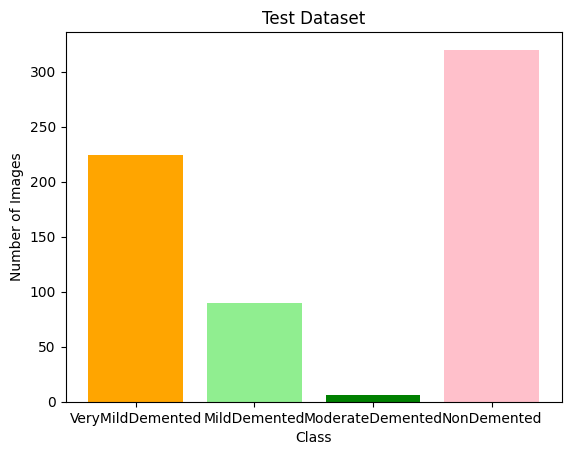

In [10]:
##  count image per class
test_counts= {class_name:len(os.listdir(os.path.join(test_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(test_counts.keys(), test_counts.values(), color=['orange','lightgreen','green','pink'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Test Dataset')
plt.show()

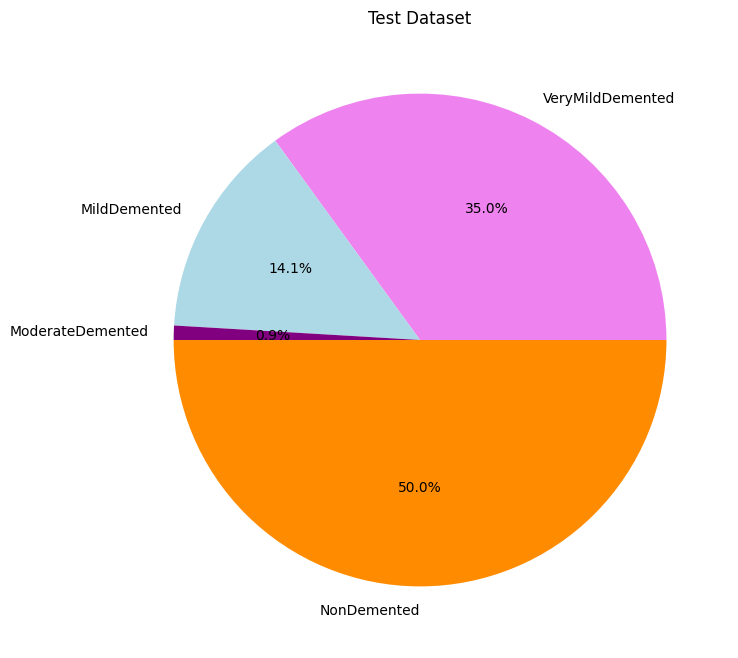

In [11]:
colors=['violet','lightblue','purple','darkorange']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(test_counts.values(),labels=test_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('Test Dataset')
plt.show()

valid dataset

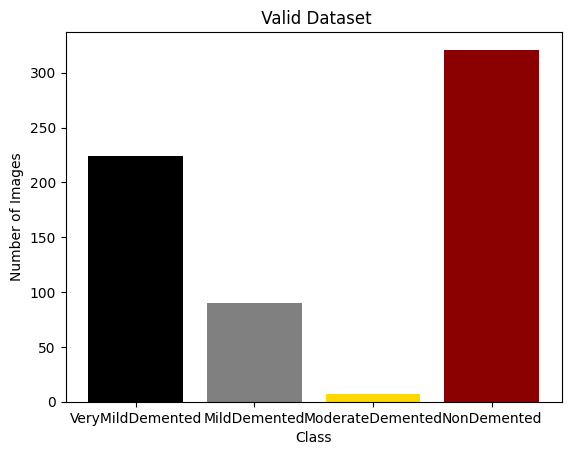

In [12]:
##  count image per class
valid_counts= {class_name:len(os.listdir(os.path.join(valid_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(valid_counts.keys(), valid_counts.values(), color=['black','grey','gold','darkred'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title(' Valid Dataset')
plt.show()

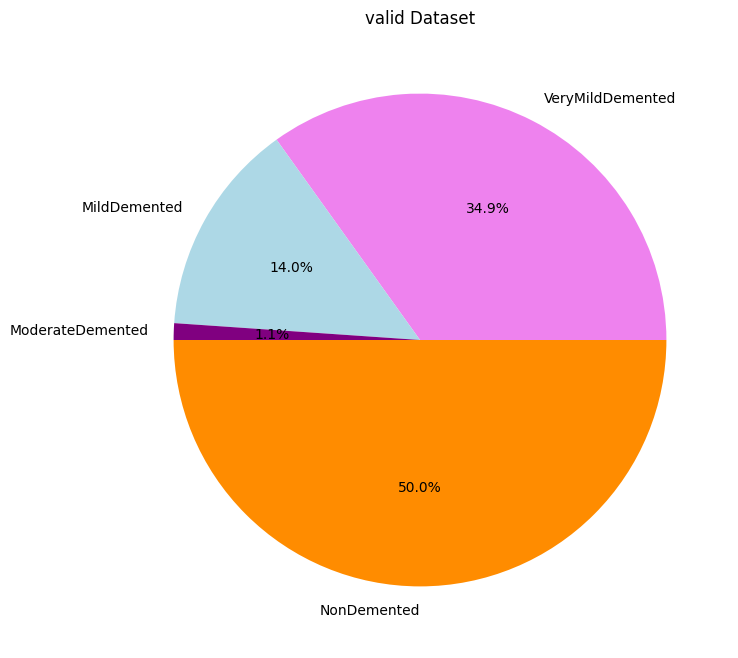

In [13]:
colors=['violet','lightblue','purple','darkorange']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(valid_counts.values(),labels=valid_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('valid Dataset')
plt.show()

## Models

In [14]:
IMG_SIZE=(150,150)
BATCH_SIZE=32

In [15]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

valid_ds = keras.preprocessing.image_dataset_from_directory(
    valid_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
# Class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")


Found 5119 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Knn model

In [16]:
# Pre-trained MobileNetV2 model for feature extraction
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Freeze the base model

# Add custom layers for feature extraction
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
model = keras.Model(inputs=base_model.input, outputs=global_avg_pooling)

# Extract features from the training data
def extract_features(dataset):
    features = []
    labels = []
    for images, labels_batch in dataset:
        feature_batch = model(images)
        features.append(feature_batch.numpy())
        labels.append(labels_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features for training, validation, and testing datasets
train_features, train_labels = extract_features(train_ds)
valid_features, valid_labels = extract_features(valid_ds)
test_features, test_labels = extract_features(test_ds)

# Normalize the features (important for KNN)
train_features = train_features / np.linalg.norm(train_features, axis=1, keepdims=True)
valid_features = valid_features / np.linalg.norm(valid_features, axis=1, keepdims=True)
test_features = test_features / np.linalg.norm(test_features, axis=1, keepdims=True)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels)

# Evaluate the model
train_pred = knn.predict(train_features)
valid_pred = knn.predict(valid_features)
test_pred = knn.predict(test_features)

# Classification report
print("Training Performance:")
print(classification_report(train_labels, train_pred, target_names=train_ds.class_names))

print("Validation Performance:")
print(classification_report(valid_labels, valid_pred, target_names=train_ds.class_names))

print("Test Performance:")
print(classification_report(test_labels, test_pred, target_names=train_ds.class_names))

<ipython-input-16-9baf6fecb0d2>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Performance:
                  precision    recall  f1-score   support

    MildDemented       0.81      0.90      0.85       716
ModerateDemented       0.68      0.82      0.74        51
     NonDemented       0.92      0.92      0.92      2560
VeryMildDemented       0.90      0.85      0.88      1792

        accuracy                           0.89      5119
       macro avg       0.83      0.87      0.85      5119
    weighted avg       0.90      0.89      0.89      5119

Validation Performance:
                  precision    recall  f1-score   support

    MildDemented       0.48      0.61      0.54        90
ModerateDemented       0.29      0.29      0.29         7
     NonDemented       0.80      0.82      0.81       321
VeryMildDemented       0.74      0.62      0.68       224

        accuracy                           0.72       642
       macro avg       0.58      0.59      0.58       642
    weighted avg       0.73   

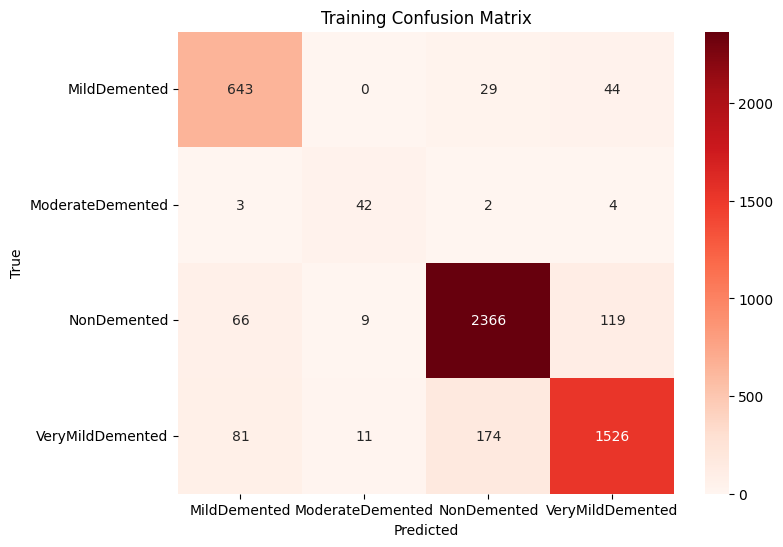

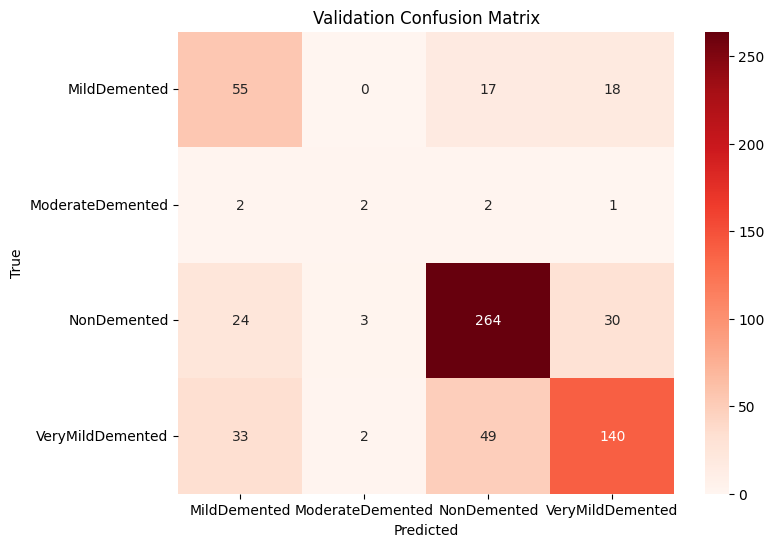

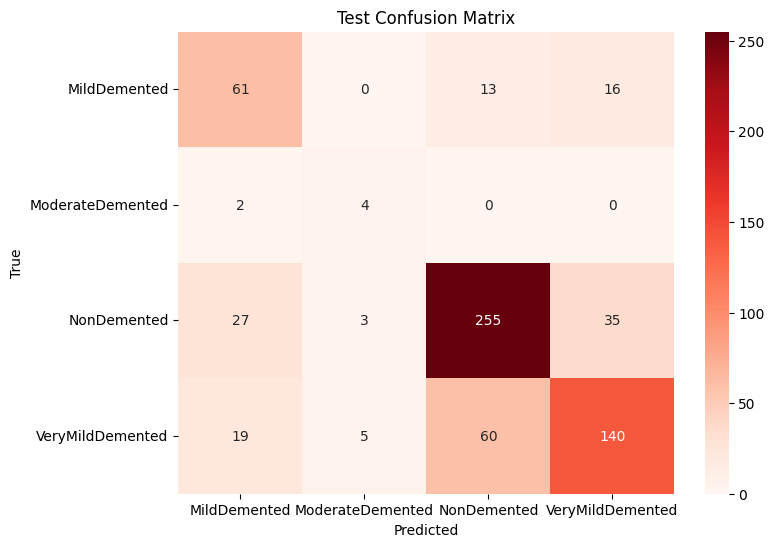

In [18]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Confusion matrix for each dataset
plot_confusion_matrix(train_labels, train_pred, train_ds.class_names, title='Training Confusion Matrix')
plot_confusion_matrix(valid_labels, valid_pred, train_ds.class_names, title='Validation Confusion Matrix')
plot_confusion_matrix(test_labels, test_pred, train_ds.class_names, title='Test Confusion Matrix')


CNN Model

In [19]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),  # Normalize
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Reduce overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,  # You can adjust the number of epochs based on your needs
    batch_size=BATCH_SIZE
),


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.4614 - loss: 1.1198 - val_accuracy: 0.5717 - val_loss: 0.9355
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.5785 - loss: 0.8930 - val_accuracy: 0.6199 - val_loss: 0.8850
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.6185 - loss: 0.8187 - val_accuracy: 0.6651 - val_loss: 0.7150
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.6894 - loss: 0.6789 - val_accuracy: 0.7430 - val_loss: 0.5879
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.7527 - loss: 0.5624 - val_accuracy: 0.8162 - val_loss: 0.4454
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.8104 - loss: 0.4322 - val_accuracy: 0.8723 - val_loss: 0.3435
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.8537 - loss: 0.3348 - val_accuracy: 0.9174 - val_loss: 0.2463
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.8837 - loss: 0.2779 - val_accu

# Model evaluation

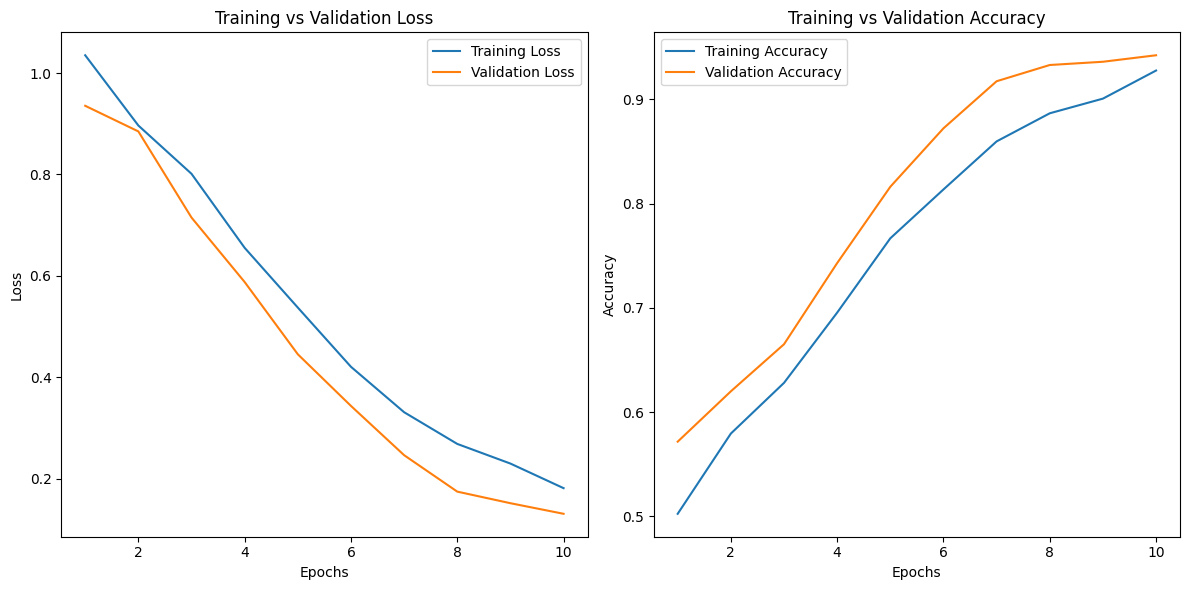

In [21]:
# Extract the training and validation accuracy and loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# Create ImageDataGenerator for preprocessing the images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Evaluate the model on the validation and test datasets
valid_loss, valid_accuracy = model.evaluate(valid_ds)
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy based on the test and validation datasets
print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - accuracy: 0.9324 - loss: 0.1500
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 558ms/step - accuracy: 0.9495 - loss: 0.1455
Validation Accuracy: 94.24%
Test Accuracy: 95.31%


Found 640 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Image Descriptions:


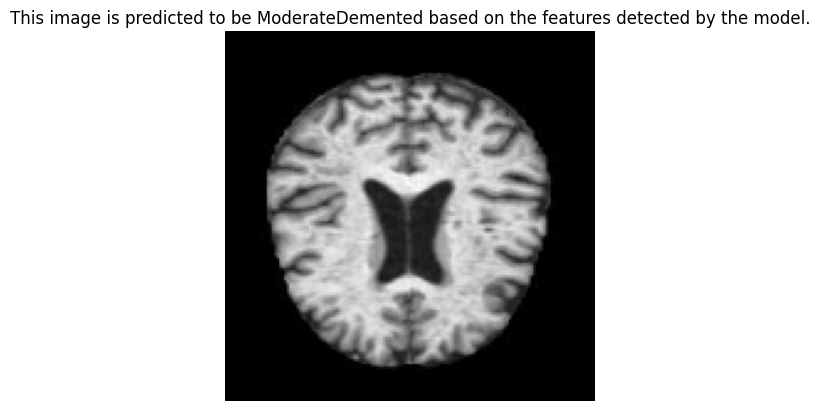

Image 1:
This image is predicted to be ModerateDemented based on the features detected by the model.
True Label: ModerateDemented
Predicted Label: ModerateDemented



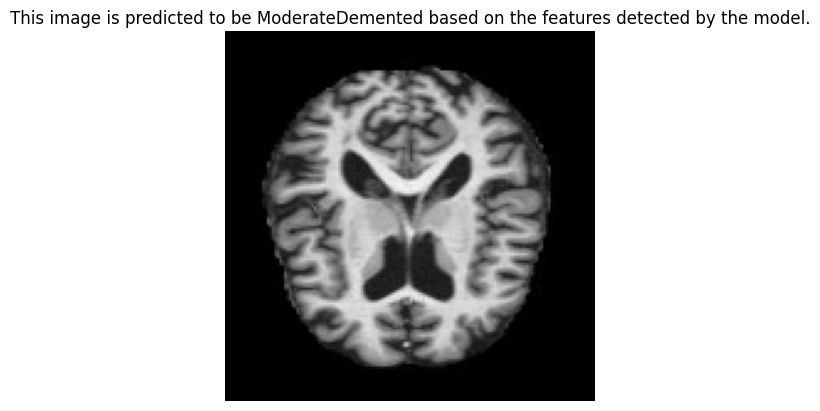

Image 2:
This image is predicted to be ModerateDemented based on the features detected by the model.
True Label: ModerateDemented
Predicted Label: ModerateDemented

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image Descriptions:


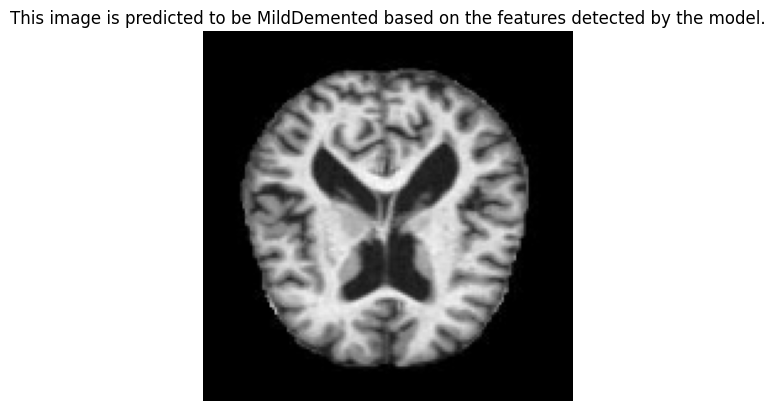

Image 1:
This image is predicted to be MildDemented based on the features detected by the model.
True Label: MildDemented
Predicted Label: MildDemented



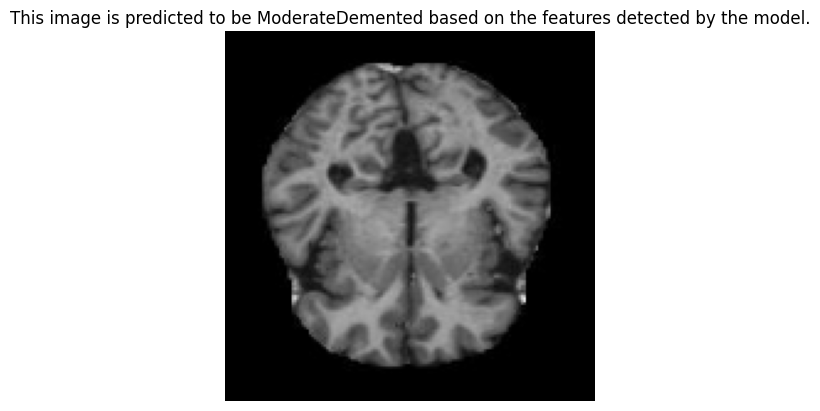

Image 2:
This image is predicted to be ModerateDemented based on the features detected by the model.
True Label: ModerateDemented
Predicted Label: ModerateDemented



In [24]:


# Directory paths (provided by you)
train_dir = '/content/drive/MyDrive/Alzheimer_dataset/dir_split/train'
test_dir = '/content/drive/MyDrive/Alzheimer_dataset/dir_split/test'
valid_dir = '/content/drive/MyDrive/Alzheimer_dataset/dir_split/valid'

# Class names based on your dataset (as you provided)
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Reset test_data generator to ensure we start from the beginning
test_data = image_dataset_from_directory(test_dir, batch_size=2, image_size=(150, 150),
                                         label_mode='categorical', shuffle=True, seed=42)

# Number of random images to evaluate
num_images = 2

# Initialize a variable to count correct predictions
correct_predictions = 0

# Randomly select num_images individual images from the entire dataset
random_images = random.sample(list(test_data.as_numpy_iterator()), num_images)

# Initialize a list to store descriptions for each image
image_descriptions = []

for i, (image_batch, label_batch) in enumerate(random_images):
    # Predict class labels for the image batch
    predictions = model.predict(image_batch)

    # Show images and display accuracy
    print("Image Descriptions:")
    for j in range(len(image_batch)):
        # Get the true label (index of the class)
        true_label = class_names[np.argmax(label_batch[j])]

        # Get the predicted label (index of the predicted class)
        predicted_label = class_names[np.argmax(predictions[j])]

        # Check if the prediction is correct
        is_correct = true_label == predicted_label
        if is_correct:
            correct_predictions += 1

        # Generate a description for the image
        description = f"This image is predicted to be {predicted_label} based on the features detected by the model."

        image_descriptions.append(description)

        # Display the image
        plt.imshow(image_batch[j] / 255.0)  # Normalize image for display
        plt.axis("off")
        plt.title(description)
        plt.show()

        # Print the description
        print(f"Image {j+1}:")
        print(description)
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {predicted_label}")
        print()


Found 640 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.98      0.92      0.95        90
VeryMildDemented       1.00      0.67      0.8

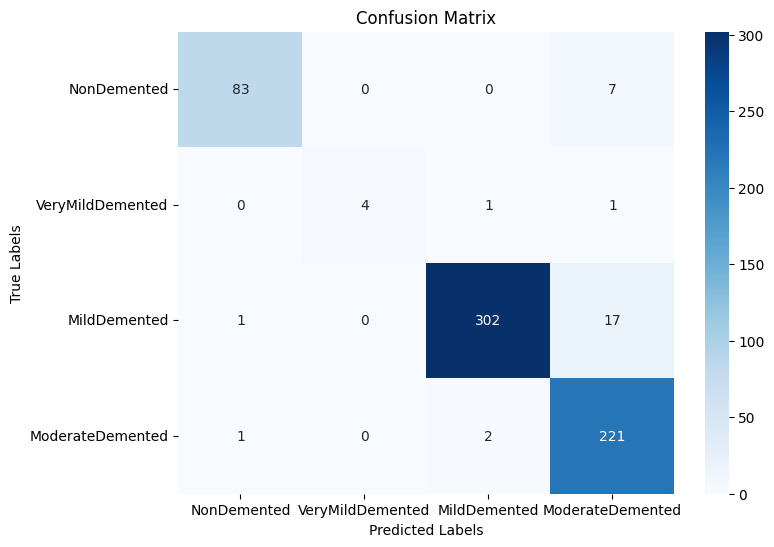

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Class names based on your dataset (as you provided)
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Reset test_data generator to ensure we start from the beginning
test_data = image_dataset_from_directory(test_dir, batch_size=32, image_size=(150, 150),
                                         label_mode='categorical', shuffle=False, seed=42)

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for image_batch, label_batch in test_data:
    # Predict class labels for the image batch
    predictions = model.predict(image_batch)

    # Get the predicted class label (highest probability)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class label (index of the class)
    true_classes = np.argmax(label_batch, axis=1)

    # Store the true and predicted labels
    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
